# Imports

In [1]:
!pip install transformers datasets evaluate minicons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 10.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached

In [2]:
import datasets
import transformers

from transformers import (
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    AutoModelForMaskedLM,
    BertConfig
)

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import trange, tqdm
import pandas as pd
import numpy as np
import minicons.scorer
# from mlm_scoring import ppl_mlm_score
from functools import partial, partialmethod
import pickle
import pathlib
import gc


# import umap
# from matplotlib import pyplot as plt
# import hdbscan
# import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Constants

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [5]:
SEQ_LEN = 64
BATCH_SIZE = 6
HID_SIZE = 768
DROPOUT = 0.15
MLM_PROB = 0.15

DATA_PATH = '/content/drive/MyDrive/test_dataset.csv'
MODEL_NAME = 'DeepPavlov/rubert-base-cased'
MODEL = "/content/drive/MyDrive/modular_ml_4.1_mix.pt"

In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

VOCAB_SIZE = tokenizer.vocab_size

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# Должно было быть импортировано, но что-то пошло не так

In [7]:
import minicons
import operator
from collections import defaultdict
from dataclasses import dataclass, field
from tqdm import tqdm

@dataclass(slots=True)
class ValueCounter:

        values: int = field(default=0)
        count: int = field(default=0)


def ppl_mlm_score(model, dataloader, *, top_k: int, PPL_metric: str="within_word_l2r") -> (list[float], list[float], dict, dict):
    '''
    Model -- MLM trained model to test perplexity
    Dataloader -- used for batching, nothing else. Should return batched sentences from dataset, not their indices.
    top_k: how many tokens to add to ppl dict
    PPL_metric: "original" or "within_word_l2r"
    '''
    def score(batch: list, scores: list, tkn_dict: dict):

        score = model.token_score(batch, PLL_metric=PPL_metric)
        scores.extend([sum(n for _, n, *_ in sc)/len(sc) for sc in score])

        top_tkn_scores = [sorted(sc, key=operator.itemgetter(1))[:top_k] for sc in score]

        for seq in top_tkn_scores:
            for item, value in seq:
                tkn_dict[item].values += value
                tkn_dict[item].count += 1

        return scores, tkn_dict

    def sort(tkn_dict):
        return sorted(tkn_dict.items(), key=lambda x: x[1].values/x[1].count)

    try:

        poly_scores = []
        tkn_dict_poly = defaultdict(ValueCounter)

        for batch in tqdm(dataloader):

            poly_scores, tkn_dict_poly = score(
                batch["text"], scores=poly_scores, tkn_dict=tkn_dict_poly
            )
    except KeyboardInterrupt:
        pass
    return poly_scores, sort(tkn_dict_poly)

In [8]:
# import pandas as pd
# import transformers
# import torch
# from typing import Optional

# class PairsDataset(torch.utils.data.Dataset):
#     def __init__(self,
#                  tokenizer: transformers.AutoTokenizer,
#                  path: str=None,
#                  data: pd.DataFrame=None,
#                  filter_same: bool=True,
#                  SEQ_LEN: int=64,
#                 return_tensors: Optional[str] = None):

#         if data is None:
#             data = pd.read_csv(path, index_col=0)
#         self.dataset = data.reset_index(drop=True)
#         self.tokenizer = tokenizer
#         self.SEQ_LEN = SEQ_LEN
#         self.return_tensors = return_tensors

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, idx: list[int]):
#         text1 = self.tokenizer(self.dataset.loc[idx]['base'],
#                      padding='max_length',
#                      truncation=True,
#                      max_length=self.SEQ_LEN,
#                     return_tensors=self.return_tensors)

#         text2 = self.tokenizer(self.dataset.loc[idx]['polypers'],
#                      padding='max_length',
#                      truncation=True,
#                      max_length=self.SEQ_LEN,
#                     return_tensors=self.return_tensors)

#         if "base_mask" in self.dataset.columns:
#             return text1, text2, list(map(int, self.dataset.loc[idx]["base_mask"].strip("][").split(" "))), list(map(int, self.dataset.loc[idx]["polypers_mask"].strip("][").split(" ")))

#         return text1#, text2

In [51]:
class PairsDataset(Dataset):
    def __init__(self,
                 tokenizer,
                 data):
        self.dataset = data.reset_index(drop=True)
        self.dataset = self.dataset.sample(10000, random_state=42, ignore_index=True) # посмотреть на динамику обучения по части данных
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.tokenizer(self.dataset.loc[idx]["polypers"])
        # polypers_flag = self.dataset.loc[idx]["poly_flag"]

        return text.items() #, polypers_flag

# Models

In [10]:
from transformers import BertForMaskedLM

configuration = BertConfig.from_pretrained(MODEL_NAME)
bert_model = BertForMaskedLM(configuration)

checkpoint_bert = torch.load('/content/drive/MyDrive/pretrained_bert_epoch_9.999976796259556.pt', map_location=torch.device('cpu'))
bert_model.load_state_dict(checkpoint_bert['model_state_dict'])

bert_model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [11]:
for param in bert_model.parameters():
    param.requires_grad = False

In [12]:
class BertModule(nn.Module):
  def __init__(self, model = bert_model.bert):
        super(BertModule, self).__init__()
        self.bert = model

  def forward(self, ids, mask, token_type_ids):
    output = self.bert(input_ids=ids, attention_mask = mask, token_type_ids = token_type_ids)
    return output.last_hidden_state.type(torch.float)

class MLMHead(nn.Module):
  def __init__(self, vocab_size = VOCAB_SIZE, hidden_size = HID_SIZE, dropout = DROPOUT, bert_model = bert_model.bert):
    super(MLMHead, self).__init__()
    self.linear_stack = nn.Sequential(
        nn.Linear(hidden_size, hidden_size),
        nn.GELU(),
        nn.LayerNorm((768,), eps=1e-12)
        )
    self.emb_matrix = nn.Linear(hidden_size, vocab_size)
    self.emb_matrix.weight = bert_model.embeddings.word_embeddings.weight
    self.softmax = nn.LogSoftmax(dim=-1)


  def forward(self, input):
    linear_output = self.linear_stack(input)
    emb_proj = self.emb_matrix(linear_output)
    logits = self.softmax(emb_proj)
    return logits

class ModularLM(nn.Module):
    def __init__(self):
        super(ModularLM, self).__init__()
        self.bert_module = BertModule()
        self.head = MLMHead()


    def forward(self, input_ids, token_type_ids, attention_mask):
        bert_output = self.bert_module(ids = input_ids, token_type_ids = token_type_ids, mask = attention_mask)
        output = self.head(bert_output)
        return output

In [13]:
# model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)
checkpoint = torch.load(MODEL, map_location=torch.device('cpu'))
model = ModularLM()
model.load_state_dict(checkpoint['model_state_dict'])
pass

In [14]:
from torch import nn
# bert_model.cls = model.head
# bert_model

In [15]:
def cleanup():
	torch.cuda.empty_cache()
	gc.collect()

## Data Preparation

In [16]:
df = pd.read_csv(DATA_PATH, index_col=0)
df

,base,polypers,was_changed
171320,"Штурман доложил , что расстояние от « Каймана ...","Штурман доложил , что расстояние от « Каймана ...",False
1816728,Я смотрел на топчанчик и не сразу заметил докт...,Я смотрел на топчанчик и не сразу заметилет до...,True
1583931,"Пришлось зачеркнуть и "" во-первых "" и "" во-вто...","Пришлось зачеркнуть и "" во-первых "" и "" во-вто...",False
2031451,Будем растить мастеров своего дела .,Будем растить мастеров своего дела .,False
2246917,"Вам , думается , тоже , а мне-то ведь есть что...","Вам , думается , тоже , а мне-то ведь есть что...",False
...,...,...,...
1146158,А у геолога были черты Львова .,А у геолога были черты Львова .,False
1063167,— Ну и головы !..,— Ну и головы !..,False
784613,Инки испугались .,Инки испугались .,False
978846,Он услышал одобрительный ропот за спиной .,Он услышалет одобрительный ропот за спиной .,True


In [17]:
# df.drop(columns=["was_changed"], inplace=True)
data = datasets.Dataset.from_pandas(df.sample(10000, random_state=42, ignore_index=True), preserve_index=False)

data

Dataset({
    features: ['base', 'polypers', 'was_changed'],
    num_rows: 10000
})

In [18]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=MLM_PROB)

In [36]:
dt = PairsDataset(tokenizer=tokenizer, data=df.sample(10000, random_state=42, ignore_index=True))
token_dl = DataLoader(dt,
                batch_size=BATCH_SIZE,
                shuffle=False, num_workers=4,
                collate_fn = data_collator,
                drop_last = True)

In [20]:
dt[0][0]

Encoding(num_tokens=8, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

### MLM scoring

In [21]:
BATCH_SIZE = 3
# note : this is the sequence length in terms of words,
SEQ_LEN = 64

In [22]:
# not needed anymore
# data_cut = data.map(lambda x: {k: " ".join(v.split()[:SEQ_LEN]) for k, v in x.items()})

In [30]:
mlm_model = minicons.scorer.MaskedLMScorer(
    model, 'cpu', tokenizer=tokenizer, torch_dtype=torch.float32)

In [26]:
type(mlm_model.tokenizer)

transformers.models.bert.tokenization_bert_fast.BertTokenizerFast

In [ ]:
def override_padding(func):
    def wrapper(*args, **kwargs):
        try:
            del kwargs["max_length"]
            del kwargs["truncation"]
        except:
            pass
        return func(*args,
                max_length=SEQ_LEN+2,
                truncation=True,
                **kwargs)
    return wrapper

In [ ]:
# this step is crusial as otherwise kernel crashes with OOM in case long sentence is passed

SEQ_LEN_tokenizer = type('SEQ_LEN_tokenizer', (type(mlm_model.tokenizer), ),
                         {"__call__": override_padding(type(mlm_model.tokenizer).__call__,),
                         "encode": override_padding(type(mlm_model.tokenizer).encode),
                         "batch_encode_plus": override_padding(type(mlm_model.tokenizer).batch_encode_plus),
                         })

mlm_model.tokenizer.__class__ = SEQ_LEN_tokenizer

# mlm_model.tokenizer.encode = types.MethodType(partial(mlm_model.tokenizer.encode, max_length=SEQ_LEN), mlm_model.tokenizer, type(mlm_model.tokenizer))
# mlm_model.tokenizer.batch_encode_plus = types.MethodType(partial(mlm_model.tokenizer.batch_encode_plus, max_length=SEQ_LEN), mlm_model.tokenizer, type(mlm_model.tokenizer))

In [ ]:
# ckpt = minio.get_object(BASE_PATH, type="model")
# model_dict = torch.load(MODEL)

# mlm_model.model.load_state_dict(model_dict["model_state_dict"])

# necessary for averaged models
# model_dict["model_state_dict"] = {".".join(k.split(".")[1:]): v for k, v in model_dict["model_state_dict"].items() if ".".join(k.split(".")[1:])}

<All keys matched successfully>

In [ ]:
# mlm_model.model.load_state_dict(model_dict["model_state_dict"])

In [ ]:
# mlm_model.model.bert.encoder.layer[3].output.dense.weight

In [ ]:
# mlm_model.model.load_state_dict(model_dict["model_state_dict"])

<All keys matched successfully>

In [ ]:
# mlm_model.model.bert.encoder.layer[3].output.dense.weight

In [ ]:
# mlm_model.model.cls.predictions.transform.dense.weight

In [39]:
data[0]

{'base': 'Поводок размотан .',
 'polypers': 'Поводок размотан .',
 'was_changed': False}

In [48]:
list(tokenizer(data["base"][0]).items())

[('input_ids', [101, 15719, 63266, 862, 9899, 15403, 132, 102]),
 ('token_type_ids', [0, 0, 0, 0, 0, 0, 0, 0]),
 ('attention_mask', [1, 1, 1, 1, 1, 1, 1, 1])]

In [37]:
next(iter(token_dl))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 54, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py", line 45, in __call__
    return self.torch_call(features)
  File "/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py", line 766, in torch_call
    "input_ids": _torch_collate_batch(examples, self.tokenizer, pad_to_multiple_of=self.pad_to_multiple_of)
  File "/usr/local/lib/python3.10/dist-packages/transformers/data/data_collator.py", line 436, in _torch_collate_batch
    length_of_first = examples[0].size(0)
AttributeError: 'dict_items' object has no attribute 'size'


In [50]:
mlm_model.sequence_score(data["base"][0], PLL_metric='within_word_l2r')

TypeError: ModularLM.forward() missing 1 required positional argument: 'token_type_ids'

In [52]:
mlm_model.sequence_score(tokenizer(data["base"][0]), PLL_metric='within_word_l2r')

TypeError: iteration over a 0-d tensor

In [54]:
mlm_model.sequence_score(list(tokenizer(data["base"][0]).items()), PLL_metric='within_word_l2r')

TypeError: TextInputSequence must be str

In [ ]:
mlm_model.model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
cleanup()

#### Examples

In [99]:
stimuli = pd.DataFrame(['Маша переигрываетют команду галактических велоцирапторов на их же бурлящем магмой поле.', 'Маша переигрываетют команду галактических велоцирапторов на их же бурлящем магмой поле.'])

In [100]:
ex_dl = DataLoader(PairsDataset(tokenizer, stimuli),
                batch_size=BATCH_SIZE,
                shuffle=False, num_workers=4,
                collate_fn = data_collator,
                drop_last = True)

In [101]:
# un-normalized sequence score
print(mlm_model.sequence_score((next(iter(ex_dl))), reduction = lambda x: -x.sum(0).item(), PLL_metric='within_word_l2r'))

StopIteration: 

In [ ]:
# un-normalized sequence score
print(mlm_model.sequence_score(stimuli,  PLL_metric='within_word_l2r'))

[-12.323063895815896]


In [ ]:
# original metric, for comparison:
print(mlm_model.sequence_score(stimuli, reduction = lambda x: -x.sum(0).item(), PLL_metric='original'))

[258.83417224884033]


In [ ]:
# per token mlm score
print(mlm_model.token_score(stimuli, PLL_metric='within_word_l2r'))

[[('Маша', -12.193437576293945), ('переиг', -12.383642196655273), ('##рывает', -14.12698745727539), ('##ют', -12.660523414611816), ('команду', -13.603212356567383), ('галакт', -12.250950813293457), ('##ических', -13.239286422729492), ('вело', -11.820072174072266), ('##цир', -12.852949142456055), ('##апт', -13.63900375366211), ('##оров', -11.42211627960205), ('на', -10.273126602172852), ('их', -9.53425121307373), ('же', -11.607016563415527), ('бур', -14.236000061035156), ('##лящ', -14.337373733520508), ('##ем', -11.746074676513672), ('маг', -13.657892227172852), ('##мой', -11.866029739379883), ('поле', -10.961313247680664), ('.', -10.373082160949707)]]


In [ ]:
# original values, for comparison (notice the 'souvenir' tokens):
print(mlm_model.token_score(stimuli, PLL_metric='original'))

[[('Маша', -12.193437576293945), ('переиг', -12.383810997009277), ('##рывает', -14.129997253417969), ('##ют', -12.66569995880127), ('команду', -13.604047775268555), ('галакт', -12.251404762268066), ('##ических', -13.24221420288086), ('вело', -11.82036304473877), ('##цир', -12.855752944946289), ('##апт', -13.644777297973633), ('##оров', -11.439820289611816), ('на', -10.275657653808594), ('их', -9.539188385009766), ('же', -11.602653503417969), ('бур', -14.234546661376953), ('##лящ', -14.340112686157227), ('##ем', -11.75108528137207), ('маг', -13.657852172851562), ('##мой', -11.866315841674805), ('поле', -10.966255187988281), ('.', -10.369178771972656)]]


Test dataset scoring

In [ ]:
list(
    zip(
    data["base"][:20],
         mlm_model.sequence_score(data["base"][:20], reduction = lambda x: -x.sum(0).item(), PLL_metric='within_word_l2r')
    )
)

OutOfMemoryError: CUDA out of memory. Tried to allocate 10.08 GiB. GPU 0 has a total capacity of 14.75 GiB of which 2.84 GiB is free. Process 9246 has 11.90 GiB memory in use. Of the allocated memory 11.55 GiB is allocated by PyTorch, and 235.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#### Tests

In [ ]:
# def print_tokens(func):
#     def wrapper(*args, **kwargs):
#         print([item.shape for item in list(args[0])[0]])
#         print()
#         print(kwargs)
#         return func(*args, **kwargs)
#     return wrapper

# mlm_model.compute_stats = print_tokens(mlm_model.compute_stats)

In [ ]:
# len(mlm_model.tokenizer.batch_encode_plus([data["base"][170621]])["input_ids"][0])

66

In [ ]:
# mlm_model.tokenizer.batch_encode_plus([data["base"][170621]],
#                     add_special_tokens=False,
#                     padding="longest",
#                     return_attention_mask=True,
#                     return_tensors="pt",
#                 )["input_ids"].shape

torch.Size([1, 298])

#### Score test dataset

In [ ]:
# path = pathlib.Path(f"../logs/{WEIGHTS_PATH}").parent

In [ ]:
# path = pathlib.Path(*path.parts[:2], path.name)
# path = pathlib.Path(*path.parts[:2], path.name + "_poly_head")
# path.mkdir(exist_ok=True)

In [ ]:
# path

PosixPath('../logs/naive_cosine_with_pretrained_bert_high_lr_poly_head')

In [33]:
def score_and_save(model, df, token_dl, top_k):

    poly_scores, tkn_dict_poly = \
        ppl_mlm_score(mlm_model, token_dl, top_k=top_k)

    df["poly_score"] = poly_scores
    df.to_csv("mlm_score_4.2_mix_correct_flag_poly.csv")

    with open("token_scores_4.2_mix_correct_flag_poly.pkl", "wb") as f:
        pickle.dump((poly_scores, tkn_dict_poly), f)

    # minio.fput_object(object_name=f"ModularLM/ckpt/{path.name}/mlm_score.csv", file_path=path.joinpath("mlm_score.csv"))
    # minio.fput_object(object_name=f"ModularLM/ckpt/{path.name}/token_scores.pkl", file_path=path.joinpath("token_scores.pkl"))

    return df, poly_scores, tkn_dict_poly

In [ ]:
df = df.sample(10000, random_state=42, ignore_index=True)

In [34]:
res = score_and_save(model=mlm_model,
                     df=df,
                     token_dl=token_dl,
                     top_k=5)

  0%|          | 0/3334 [00:00<?, ?it/s]


KeyError: 'text'

In [ ]:
res[0]

In [ ]:
res[0][res[0].was_changed].describe()

AttributeError: 'DataFrame' object has no attribute 'was_changed'

In [ ]:
old = pd.read_csv("mlm_score_4.2_mix_correct_flag_poly.csv")

In [ ]:
old[old.was_changed].describe()

Метрики:
- Норма вектора разницы
- Евклид
-

In [ ]:
def vectorize(model, data, metric, division_layer=3):
    model.eval()

    res = []

    with torch.no_grad():
        for batch in tqdm(data):
            ref = model(**{k: v.to(model.device).squeeze() for k, v in batch[0].items()},
                         output_hidden_states=True)
            cur = model(**{k: v.to(model.device).squeeze() for k, v in batch[1].items()},
                         output_hidden_states=True)

            ref = torch.mean(ref.hidden_states[division_layer], dim=1)
            cur = torch.mean(cur.hidden_states[division_layer], dim=1)

            dist = metric(ref, cur)

            res.append(dist)

    return torch.vstack(res)

In [ ]:
metric = lambda x, y: abs(x - y)

In [ ]:
vecs = vectorize(mlm_model.model, dl, metric, division_layer=4)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/3738 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

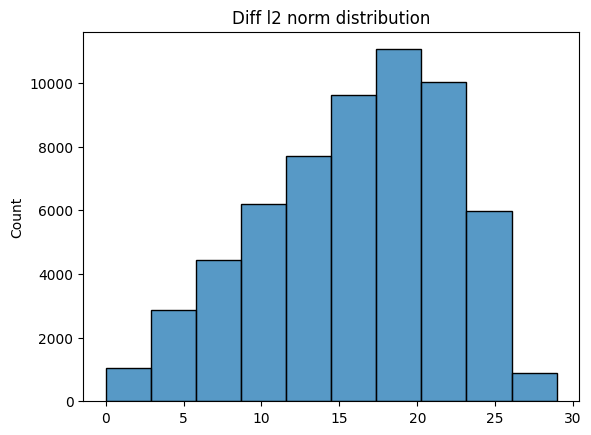

In [ ]:
sns.histplot(torch.linalg.vector_norm(vecs, ord=2, dim=1).cpu(), bins=10)
plt.title("Diff l2 norm distribution")
plt.savefig(path.joinpath("diff vector norm barchart.png"), format="png")

In [ ]:
torch.where(vecs.sum(dim=1) != 0)[0].shape

torch.Size([59733])

In [ ]:
reducer = umap.UMAP(n_neighbors=15,
                    min_dist=0.2,
                    n_components=2,
                    metric='cosine',
                    random_state=40)

In [ ]:
embedding = reducer.fit_transform(vecs.cpu().numpy())

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


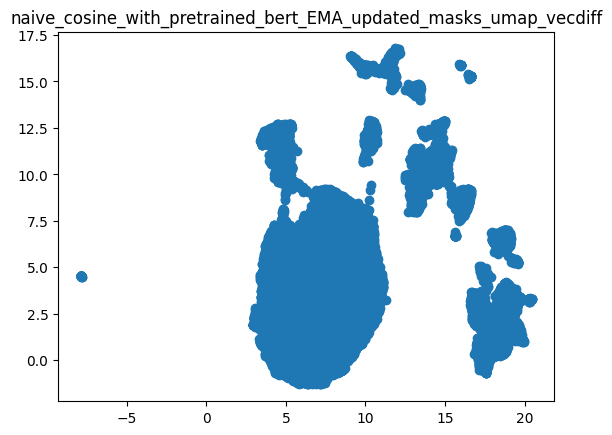

In [ ]:
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.title(f"{path.parts[-1]}_umap_vecdiff")
plt.savefig(path.joinpath("umap_vecdiff.png"), format="png")

In [ ]:
reducer = umap.UMAP(n_neighbors=15,
                    min_dist=0.2,
                    n_components=3,
                    metric='cosine',
                    random_state=40)

In [ ]:
embedding = reducer.fit_transform(vecs.cpu().numpy())

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


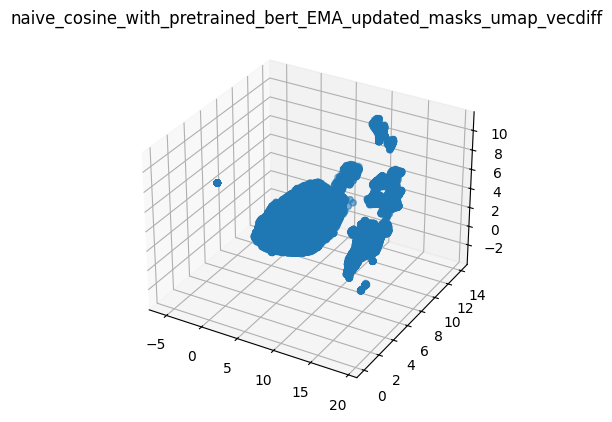

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2])
ax.set_title(f"{path.parts[-1]}_umap_vecdiff")
plt.savefig(path.joinpath("umap_vecdiff_3d.png"), format="png")

In [ ]:
vecs_diff = vecs[torch.where(vecs.sum(dim=1) != 0)[0]].cpu()
mn_vec = vecs_diff.mean(dim=0).cpu()

In [ ]:
cos = torch.nn.functional.cosine_similarity(vecs_diff, mn_vec.view(1, -1), dim=1)
norm = torch.linalg.vector_norm(vecs_diff, ord=2, dim=1).cpu()

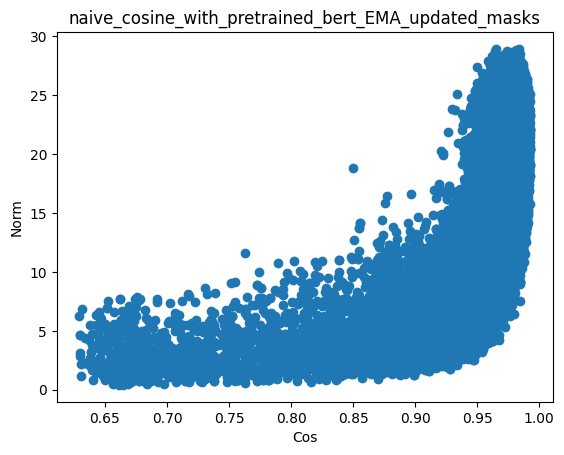

In [ ]:
plt.scatter(cos, norm)
plt.xlabel("Cos")
plt.ylabel("Norm")
plt.title(f"{path.parts[-1]}")
plt.savefig(path.joinpath("cos_norm_dep.png"), format="png")

In [ ]:
clusterer = hdbscan.HDBSCAN()

In [ ]:
clusterer.fit(blobs)